## Load Data

In [1]:
import csv
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

correction = 0.2 # this is a parameter to tune  

# Load CSV containg image data1
lines = []
#with open('driving_log.csv') as csvfile:
with open('data/driving_log.csv') as csvfile:    
    reader = csv.reader(csvfile)
    next(reader, None)  # skip the headers
    for line in reader:
        lines.append(line)

# since we are on AWS need  but the paths in$
# of the file are for windows we need to spl$
# the path for AWS

#pull out center, left, and right cameras
#split path on / and pull out filename
images = [] #list of all images
measurements = [] #list of corresponding steering angle
for line in lines:
    for i in range(3):
        source_path = line[i]
        filename = source_path.split('/')[-1] #use ('\\') for windows
        #current_path = 'IMG/' + filename
        current_path = 'data/IMG/' + filename
        image = cv2.imread(current_path)
        images.append(image) # Store images as a list
        measurement = float(line[3]) #center
        if i==0:
            measurements.append(measurement) #store steering angle as list
        elif i==1:
            measurement+=correction
            measurements.append(measurement) #left
        elif i==2:
            measurement-=correction
            measurements.append(measurement) #right
            
#convert dataset to numpy arrays
data1_x_train = np.array(images)
data1_y_train = np.array(measurements)
del images
del measurements
del lines


# Load CSV containg image data2
lines = []
#with open('driving_log.csv') as csvfile:
with open('data2/driving_log.csv') as csvfile:    
    reader = csv.reader(csvfile)
    next(reader, None)  # skip the headers
    for line in reader:
        lines.append(line)

# since we are on AWS need  but the paths in$
# of the file are for windows we need to spl$
# the path for AWS

#pull out center, left, and right cameras
#split path on / and pull out filename
images = [] #list of all images
measurements = [] #list of corresponding steering angle
for line in lines:
    for i in range(3):
        source_path = line[i]
        filename = source_path.split('\\')[-1] #use ('\\') for windows
        #current_path = 'IMG/' + filename
        current_path = 'data2/IMG/' + filename
        image = cv2.imread(current_path)
        images.append(image) # Store images as a list
        measurement = float(line[3]) #center
        if i==0:
            measurements.append(measurement) #store steering angle as list
        elif i==1:
            measurement+=correction
            measurements.append(measurement) #left
        elif i==2:
            measurement-=correction
            measurements.append(measurement) #right

#convert dataset to numpy arrays
data2_x_train = np.array(images)
data2_y_train = np.array(measurements)
del images
del measurements
del lines

# Load CSV containg image data3
lines = []
#with open('driving_log.csv') as csvfile:
with open('data3/driving_log.csv') as csvfile:    
    reader = csv.reader(csvfile)
    next(reader, None)  # skip the headers
    for line in reader:
        lines.append(line)

# since we are on AWS need  but the paths in$
# of the file are for windows we need to spl$
# the path for AWS

#pull out center, left, and right cameras
#split path on / and pull out filename
images = [] #list of all images
measurements = [] #list of corresponding steering angle
for line in lines:
    for i in range(3):
        source_path = line[i]
        filename = source_path.split('\\')[-1] #use ('\\') for windows
        #current_path = 'IMG/' + filename
        current_path = 'data3/IMG/' + filename
        image = cv2.imread(current_path)
        images.append(image) # Store images as a list
        measurement = float(line[3]) #center
        if i==0:
            measurements.append(measurement) #store steering angle as list
        elif i==1:
            measurement+=correction
            measurements.append(measurement) #left
        elif i==2:
            measurement-=correction
            measurements.append(measurement) #right

#convert dataset to numpy arrays
data3_x_train = np.array(images)
data3_y_train = np.array(measurements)
del images
del measurements
del lines


X_train = np.concatenate((data1_x_train,data2_x_train,data3_x_train), axis=0)
y_train = np.concatenate((data1_y_train,data2_y_train,data3_y_train), axis=0)




print ("X_train Images Shape", X_train.shape)
print ("y_train Steering Angle Shape", y_train.shape)

X_train Images Shape (73779, 160, 320, 3)
y_train Steering Angle Shape (73779,)


## Histogram vs Angle

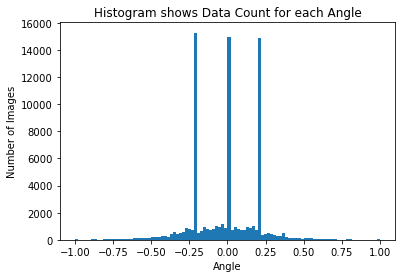

In [2]:

# histogram of label frequency
plt.hist(y_train, bins=100, range=(-1,1))
plt.title("Histogram shows Data Count for each Angle")
plt.xlabel("Angle")
plt.ylabel("Number of Images")
plt.show()

In [3]:
bins = 100                 # N of bins
bin_n = 500                 # N of examples to include in each bin (at most)

X_train_norm = []
y_train_norm = []


for low in np.linspace(-1, 1, 2*bins+1):
    idx = (y_train>low)*(y_train<(low+1/bins))
    all_index = np.where(idx)[0]
    #print(all_index)
    if len(all_index) >= bin_n:
        rand = (np.random.choice(all_index, bin_n, replace=False))
        for a in rand:
            X_train_norm.append(X_train[a])
            y_train_norm.append(y_train[a])
        
    elif len(all_index > 0):
        for b in all_index:
            X_train_norm.append(X_train[b])
            y_train_norm.append(y_train[b])
                 
        

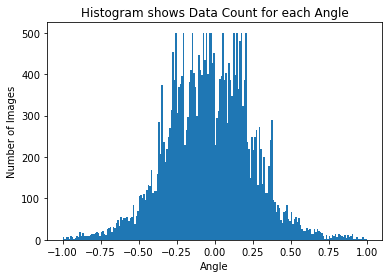

In [4]:
# histogram of label frequency
plt.hist(y_train_norm, bins=200, range=(-1,1))
plt.title("Histogram shows Data Count for each Angle")
plt.xlabel("Angle")
plt.ylabel("Number of Images")
plt.show()

## Overwrite Data with Normalized Distribution

In [5]:
X_train = np.array(X_train_norm)
y_train = np.array(y_train_norm)
print ("X_train Images Shape", X_train.shape)
print ("y_train Steering Angle Shape", y_train.shape)
del X_train_norm
del y_train_norm





X_train Images Shape (30035, 160, 320, 3)
y_train Steering Angle Shape (30035,)


## Random Shadows
It was noticed that driving down the track there were many lighting condition changes.
We Augment the Data further by adding random shadows to the images to help increase generalization

To add a random shadow, 2 points are selected along the width of the image. A line is calculated between the points, and the pixel are ajusted on one side of the vertical line to add a "Shadow"


In [6]:
#get shape of image
def randomShadow(image):
    temp_img = np.copy(image)
    h, w = temp_img.shape[0], temp_img.shape[1]

    #Select two points along image width at random
    [x1, x2] = np.random.choice(w, 2, replace=False)

    #find line equation between to points, with both points on axis
    k = h / (x2 - x1)
    b = - k * x1

    #multiply pixel to affect brightness
    for i in range(h):
        c = int((i - b) / k)
        temp_img[i, :c, :] = (temp_img[i, :c, :] * .5).astype(np.int32)

    return temp_img 

## Example Random Shadow

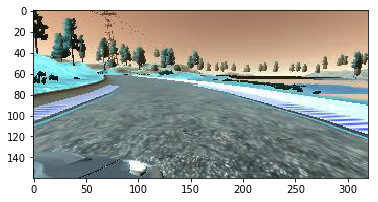

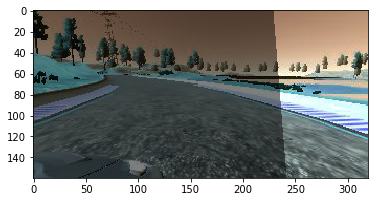

In [7]:
fig = plt.figure()
plt.imshow(X_train[0])  

fig = plt.figure()
plt.imshow(randomShadow(X_train[0]))  


In [8]:
shadow_images = []
shadow_measurements = []
for idx,image in enumerate(X_train):
    shadow_images.append(randomShadow(image))
    shadow_measurements.append(y_train[idx])
    
#Concatenate Data
X_train = np.concatenate((X_train,np.array(shadow_images)), axis=0)
y_train = np.concatenate((y_train,np.array(shadow_measurements)), axis=0)
print ("X_train Images Shape", X_train.shape)
print ("y_train Steering Angle Shape", y_train.shape)
del shadow_images
del shadow_measurements

X_train Images Shape (60070, 160, 320, 3)
y_train Steering Angle Shape (60070,)


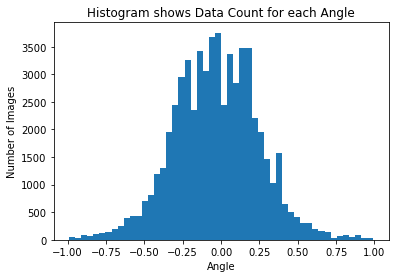

In [9]:

# histogram of label frequency
plt.hist(y_train, bins=50)
plt.title("Histogram shows Data Count for each Angle")
plt.xlabel("Angle")
plt.ylabel("Number of Images")
plt.show()

## Data Augmentation - Flip

In [10]:
augmented_images, augmented_measurements = [],[]

for image, measurement in zip(X_train, y_train):
        augmented_images.append(image)
        augmented_measurements.append(measurement)
        augmented_images.append(cv2.flip(image,1))
        augmented_measurements.append(measurement*-1.0)

X_train = np.array(augmented_images)
y_train = np.array(augmented_measurements)

#Save some images to plot
exampleImages = []
exampleImages.append(X_train[0]) #Center
exampleImages.append(X_train[1]) #Left
exampleImages.append(X_train[2]) #Right

exampleImages.append(augmented_images[0])
exampleImages.append(augmented_images[1])
exampleImages.append(augmented_images[2])

print ("X_train Images Shape", X_train.shape)
print ("y_train Steering Angle Shape", y_train.shape)
del augmented_images
del augmented_measurements        

X_train Images Shape (120140, 160, 320, 3)
y_train Steering Angle Shape (120140,)


In [11]:
## Example Flip

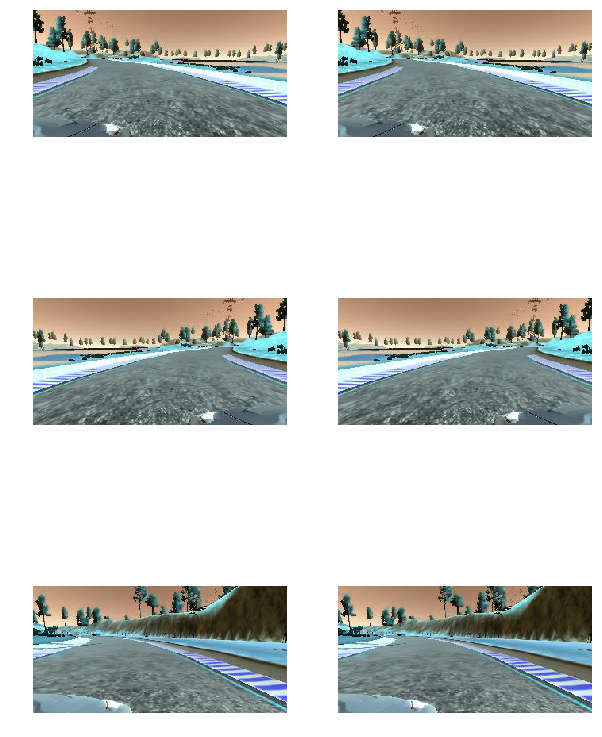

In [12]:

#create 5x5 subplot window
fig, ax = plt.subplots(3,2,figsize=(10, 12))
ax = ax.ravel()

#for each category, find random 5 indicies of their occurance, and plot the image
for i, img in enumerate(exampleImages):
    ax[i].imshow(img)
    ax[i].axis('off')
    

## Histogram vs Angle

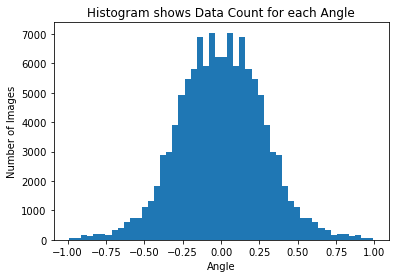

In [13]:

# histogram of label frequency
plt.hist(y_train, bins=50)
plt.title("Histogram shows Data Count for each Angle")
plt.xlabel("Angle")
plt.ylabel("Number of Images")
plt.show()

## Visualize Final Dataset

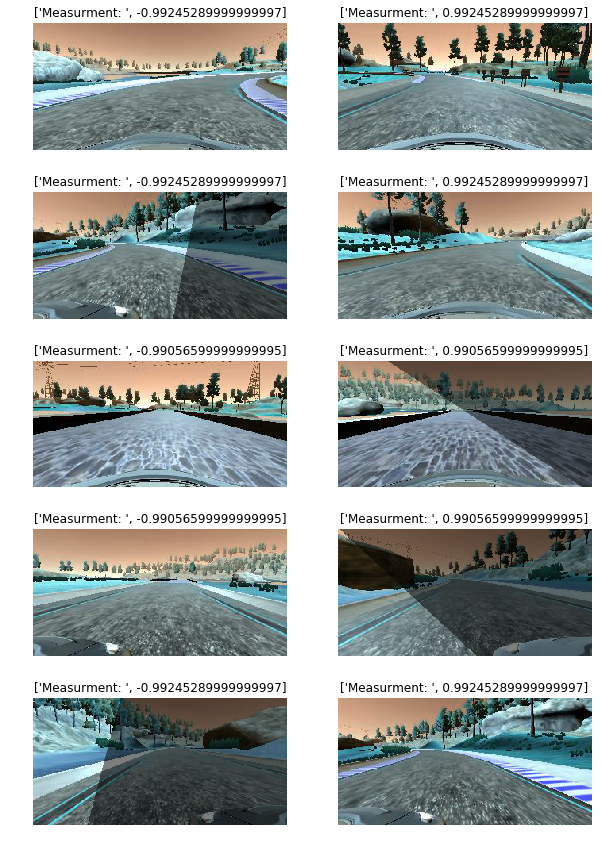

In [14]:
i_range = random.sample(range(1, len(X_train)), 10)
#print (i_range)

#create 5x5 subplot window
fig, ax = plt.subplots(5,2,figsize=(10, 15))
ax = ax.ravel()

#for each category, find random 5 indicies of their occurance, and plot the image
for i, cat in enumerate(i_range):
    img = X_train[cat]
    ax[i].imshow(img)
    ax[i].axis('off')
    ax[i].set_title(['Measurment: ',y_train[i]])
    

## Keras Nueral Network - Regression Network

In [15]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers import Cropping2D


model = Sequential()
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160,320,3)))
model.add(Cropping2D(cropping=((50,20), (0,0))))
model.add(Convolution2D(24,5,5, subsample=(2,2), activation='elu'))
model.add(Convolution2D(36,5,5, subsample=(2,2), activation='elu'))
model.add(Convolution2D(48,5,5, subsample=(2,2), activation='elu'))
model.add(Convolution2D(64,3,3, activation='elu'))
model.add(Convolution2D(64,3,3, activation='elu'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))


model.compile(loss='mse', optimizer='adam')
history_object = model.fit(X_train, y_train, validation_split=0.3, shuffle=True, nb_epoch=4)

model.save('model.h5')

Using TensorFlow backend.


Train on 84098 samples, validate on 36042 samples
Epoch 1/4
84098/84098 [==============================] - 243s - loss: 0.0484 - val_loss: 0.0867
Epoch 2/4
84098/84098 [==============================] - 233s - loss: 0.0401 - val_loss: 0.0817
Epoch 3/4
84098/84098 [==============================] - 233s - loss: 0.0362 - val_loss: 0.0871
Epoch 4/4
84098/84098 [==============================] - 233s - loss: 0.0331 - val_loss: 0.0741


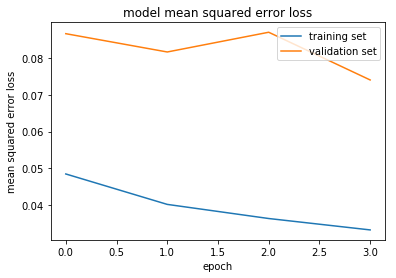

In [17]:
### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()